In [5]:
import tensorflow.keras as keras
import numpy as np
import importlib

import kaggle_functions as kaggle
import model10_wideresnet
importlib.reload(kaggle); 
importlib.reload(model10_wideresnet);
from model10_wideresnet import Model

model_number = 'model10'

### Create datasets

In [3]:
train_dataset, valid_dataset, valid_labels = kaggle.load_train_as_dataset()

batch_size = 32
train_dataset_augmented, epoch_length = kaggle.augment_dataset(train_dataset, batch_size)

In [ ]:
kaggle.show_images(train_dataset_augmented, 9)

### Train new model

In [7]:
Model().build(None).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 48, 48, 32)   320         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 48, 48, 32)  128         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 re_lu_7 (ReLU)                 (None, 48, 48, 32)   0           ['batch_normalization_7[0][

In [11]:
# Fit model
# See {model}.py for specific training instructions, like epochs or valid_patience
model_name = 'WideResNet_2'

model, history = kaggle.train_model(
    Model().build(None), train_dataset_augmented, valid_dataset, 
    epochs=200, valid_patience=20, epoch_length=epoch_length)

Epoch 1/200
298/298 [==============================] - 153s 501ms/step - loss: 3.1009 - accuracy: 0.2196 - val_loss: 2.9957 - val_accuracy: 0.2283 - lr: 5.0000e-04
Epoch 2/200
298/298 [==============================] - 149s 500ms/step - loss: 2.8079 - accuracy: 0.2819 - val_loss: 3.4188 - val_accuracy: 0.2166 - lr: 5.0000e-04
Epoch 3/200
298/298 [==============================] - 149s 500ms/step - loss: 2.5835 - accuracy: 0.3184 - val_loss: 2.9230 - val_accuracy: 0.2763 - lr: 5.0000e-04
Epoch 4/200
298/298 [==============================] - 149s 499ms/step - loss: 2.4043 - accuracy: 0.3480 - val_loss: 2.7913 - val_accuracy: 0.3162 - lr: 5.0000e-04
Epoch 5/200
298/298 [==============================] - 125s 421ms/step - loss: 2.2840 - accuracy: 0.3726 - val_loss: 2.8413 - val_accuracy: 0.2733 - lr: 5.0000e-04
Epoch 6/200
298/298 [==============================] - 120s 403ms/step - loss: 2.1573 - accuracy: 0.3987 - val_loss: 2.7450 - val_accuracy: 0.3087 - lr: 5.0000e-04
Epoch 7/200
298/

INFO:tensorflow:Assets written to: models/model10/WideResNet_2\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


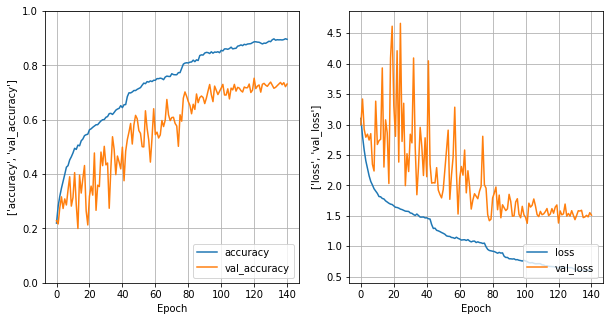

In [12]:
# Save model
model.save(f'models/{model_number}/{model_name}')

# Plot model statistics during training
kaggle.plot_model_history(history, [['accuracy', 'val_accuracy'], ['loss', 'val_loss']])

### Fine-tune

In [17]:
# Fine-tune model
fine_model, history = kaggle.fine_tune_model(
    model,
    train_dataset.batch(32), valid_dataset, 
    epochs=4, epoch_length=epoch_length, learning_rate=0.00001)

298/298 [==============================] - 171s 549ms/step - loss: 0.2889 - accuracy: 0.9958 - val_loss: 0.9523 - val_accuracy: 0.8452


In [16]:
# Save fine-tuned model
fine_model_name = 'WideResNet_5_84'
fine_model.save(f'models/{model_number}/{fine_model_name}')

INFO:tensorflow:Assets written to: models/model10/WideResNet_5_84\assets


C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\Guillaume\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


### Evaluate

In [ ]:
model_name = ''
model = keras.models.load_model(f'models/{model_number}/{model_name}')
test_pred = np.argmax(model.predict(valid_dataset.batch(128)), axis=1)

kaggle.print_accuracy(valid_labels, test_pred)
kaggle.plot_confusion_matrix(valid_labels, test_pred)

### Generate test predictions

In [ ]:
model_name = 'WideResNet_3'
kaggle.generate_test_pred_filepath(f'models/{model_number}/{model_name}')

### Hypertune models

In [6]:
tuner = kaggle.hypertune_model(
    Model(), train_dataset_augmented, valid_dataset, 
    model_number, 'hypertuner2021-12-03', trials=4, 
    epochs=200, epoch_length=epoch_length, valid_patience=20)

Trial 3 Complete [06h 51m 28s]
val_accuracy: 0.8048780560493469

Best val_accuracy So Far: 0.8048780560493469
Total elapsed time: 14h 08m 54s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
conv_dropout      |0.3               |0.5               
k                 |12                |9                 

Epoch 1/200
298/298 [==============================] - 221s 715ms/step - loss: 3.5310 - accuracy: 0.2394 - val_loss: 4.8750 - val_accuracy: 0.1413 - lr: 5.0000e-04
Epoch 2/200
298/298 [==============================] - 209s 700ms/step - loss: 3.0394 - accuracy: 0.2889 - val_loss: 3.8850 - val_accuracy: 0.1913 - lr: 5.0000e-04
Epoch 3/200
298/298 [==============================] - 209s 701ms/step - loss: 2.6856 - accuracy: 0.3263 - val_loss: 3.2573 - val_accuracy: 0.2090 - lr: 5.0000e-04
Epoch 4/200
298/298 [==============================] - 207s 694ms/step - loss: 2.4183 - accuracy: 0.3504 - val_loss: 5.1105 - val_accuracy: 0.1493 - lr: 5.0000e-04
Epo

In [7]:
[model, model2] = tuner.get_best_models(2)

In [2]:
tuner = kaggle.load_hypertuner(Model(), model_number, 'hypertuner2021-12-01')

INFO:tensorflow:Reloading Oracle from existing project models/model10\hypertuner2021-11-30\oracle.json
INFO:tensorflow:Reloading Tuner from models/model10\hypertuner2021-11-30\tuner0.json
Results summary
Results in models/model10\hypertuner2021-11-30
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_dropout: 0.3
n: 2
Score: 0.7708157896995544
Trial summary
Hyperparameters:
conv_dropout: 0.6
n: 1
Score: 0.6917577981948853
